# Projet CNN : Qui a peint ce tableau ?

## 1) Chargement des librairies

In [1]:
import os
import sys
import math
import random as rd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

2024-12-17 17:31:12.141582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 17:31:12.161368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 17:31:12.167216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 17:31:12.182011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 17:31:14.972292: W tensorflow/comp

In [2]:
print([k.device_type for k in tf.config.list_physical_devices()])

# Désactive le GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

['CPU', 'GPU']


## 2) Chargement des données

Dans un premier temps, nous avons tenté d'utiliser les images en haute définition, mais nous avons rencontré des difficultés lors de l'entraînement. En effet, nous avons rapidement saturé la mémoire du GPU. Pour contourner ce problème, nous aurions dû redimensionner les images à une taille plus petite, ce qui aurait entraîné une perte de qualité. Ainsi, nous avons décidé de nous concentrer sur des données de basse résolution directement.

In [3]:
# Chemin des données
path = os.path.join(os.getcwd(), "art-challenge", "images_lq")

# Chargement des données
data = []
for image_file in os.listdir(path):
    artist = "_".join(image_file.split("_")[:-1])
    image_path = os.path.join(path, image_file)
    with Image.open(image_path) as image:
        width, height = image.size
    data.append({"image_path": image_path,
                 "artist": artist,
                 "width": width,
                 "height": height})
data = pd.DataFrame(data)
data.head()

,image_path,artist,width,height
0,/home/cailla/Bureau/5_GMM/Projets_HDDL/Projet_...,Albrecht_Dürer,432,614
1,/home/cailla/Bureau/5_GMM/Projets_HDDL/Projet_...,Albrecht_Dürer,896,1229
2,/home/cailla/Bureau/5_GMM/Projets_HDDL/Projet_...,Albrecht_Dürer,402,614
3,/home/cailla/Bureau/5_GMM/Projets_HDDL/Projet_...,Albrecht_Dürer,292,461
4,/home/cailla/Bureau/5_GMM/Projets_HDDL/Projet_...,Albrecht_Dürer,910,1229


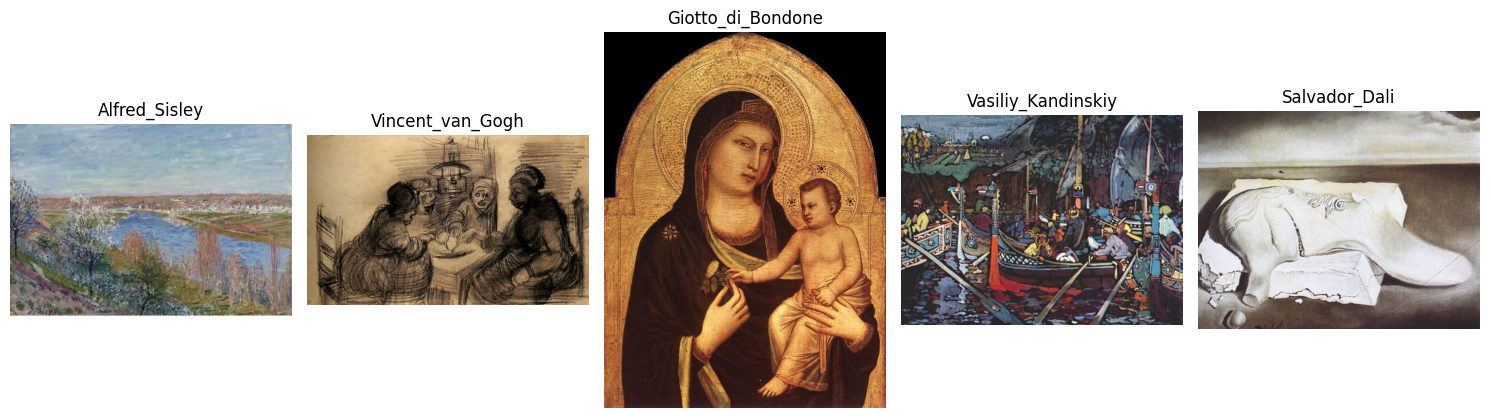

In [4]:
# Affiche des tableaux au hasard
random_idx = rd.sample(range(len(data)), 5)
plt.figure(figsize = (15, 5))
for i, idx in enumerate(random_idx):
    img = Image.open(data.loc[idx, "image_path"]).convert("RGB")
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(data.loc[idx, "artist"])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 3) Analyse exploratoire des données

### a) Etude du nombre de peinture pour chaque artiste

Dans un premier temps, observons la répartition du nombre de peintures pour chaque artiste pour voir si la base de données est équilibrée.

In [5]:
def histogram_images_per_artist(df, threshold = True):
    
    # Compte le nombre d'images pour chaque artiste
    counter_artists = Counter(df["artist"])
    
    # Trie les artistes par nombre d'images décroissant
    sorted_artists = sorted(counter_artists.items(), key = lambda x: x[1], reverse = True)
    names = [artist for artist, _ in sorted_artists]
    counts = [count for _, count in sorted_artists]
    
    # Seuils sur du nombre d'images par artiste
    min = 120
    max = 300
    
    # Histogramme
    plt.figure(figsize = (10, 7))
    plt.bar(names, counts, color = "skyblue")
    if threshold:
        plt.axhline(max, color = "green", linestyle = "--", label = "Limite haute : " + str(max) + " images")
        plt.axhline(min, color = "red", linestyle = "--", label = "Limite basse : " + str(min) + " images")
        plt.legend(fontsize = 12)
    plt.xticks(rotation = 90, ha = "center")
    plt.xlabel("Artistes", fontsize = 12)
    plt.ylabel("Nombre de peintures", fontsize = 12)
    plt.title("Nombre de peintures par artiste", fontsize = 15)
    plt.tight_layout()
    plt.show()

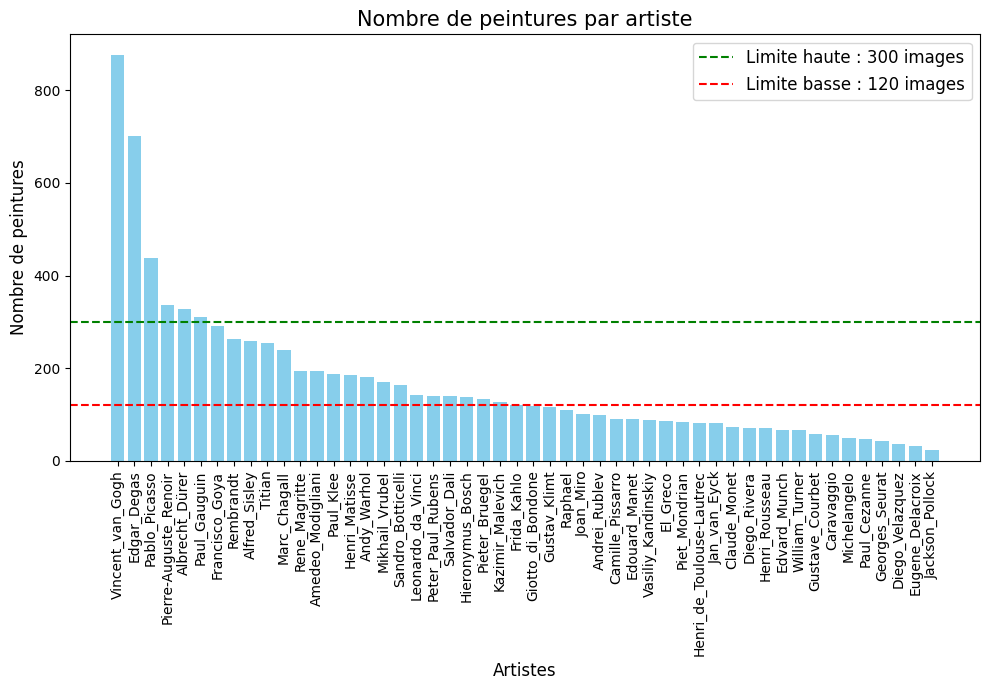

In [6]:
histogram_images_per_artist(data, True)

Nos données présentent un déséquilibre notable. Certains artistes comptent moins de 120 tableaux, ce qui nous amène à les exclure. D'autres, comme Vincent Van Gogh, Edgar Degas ou Pablo Picasso, sont surreprésentés. Pour tous ces artistes ayant plus de 300 oeuvres, nous réduirons leur nombre en retirant aléatoirement des tableaux afin d'équilibrer la distribution.

In [7]:
filtered_data = data.copy()

# Supprime les artistes avec moins de 120 tableaux
counter_artists = Counter(data["artist"])
artists_to_keep = [artist for artist, count in counter_artists.items() if count >= 120]
filtered_data = data[data["artist"].isin(artists_to_keep)]

# Réduit le nombre d'image maximum à 300
artists_reduced = []
for artist, count in filtered_data.groupby("artist"):
    if len(count) > 300:
        sample = count.sample(n = 300)
    else:
        sample = count
    artists_reduced.append(sample)
filtered_data = pd.concat(artists_reduced, ignore_index = True)

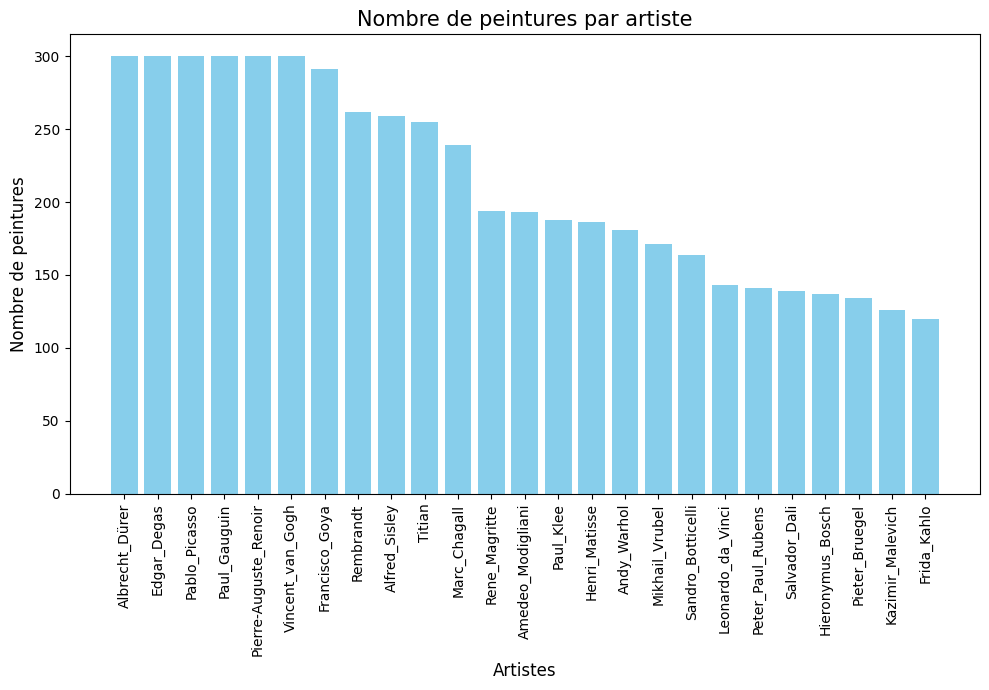

In [8]:
histogram_images_per_artist(filtered_data, False)

In [9]:
print("Nombre initial de tableaux : ", len(data))
print("Nombre initial d'artistes : ", len(data["artist"].unique()), "\n")

print("Nouveau nombre de tableaux : ", len(filtered_data))
print("Nouveau nombre d'artistes : ", len(filtered_data["artist"].unique()))

Nombre initial de tableaux :  8355
Nombre initial d'artistes :  50 

Nouveau nombre de tableaux :  5323
Nouveau nombre d'artistes :  25


### b) Etude des dimensions des images

Ensuite nous allons comparer les différentes dimensions des peintures.

In [10]:
def boxplot_dimensions(df):
    
    # Récupère les dimensions
    height = df["height"]
    width = df["width"]

    # Calcul des médianes
    median_height = height.median()
    median_width = width.median()

    # Boxplot
    plt.figure(figsize = (8, 5))
    plt.boxplot([height, width],
                patch_artist = True,
                boxprops = dict(facecolor = "lightblue"),
                medianprops = dict(color = "red"),
                flierprops = dict(marker = ".", markersize = 3),
                widths = 0.3)
    plt.text(1, median_height + 0.015 * median_height, str(median_height), color = "red", ha = "center", fontsize = 9)
    plt.text(2, median_width + 0.015 * median_width, str(median_width), color = "red", ha = "center", fontsize = 9)
    plt.xticks([1, 2], ["Longueur", "Largeur"])
    plt.ylabel("Nombre de pixel", fontsize = 12)
    plt.title("Boxplot des dimensions des images", fontsize = 15)
    plt.tight_layout()
    plt.show()

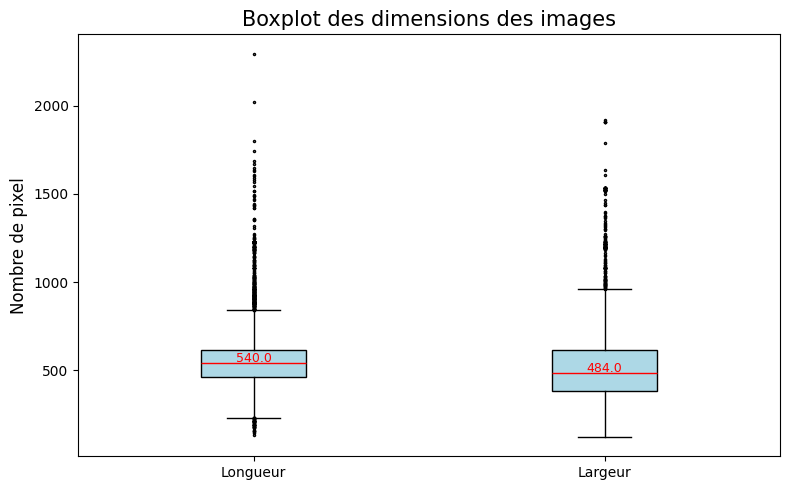

In [11]:
boxplot_dimensions(filtered_data)

A la vue de ces boxplot, nous avons décidé que nous redimensionnerons toutes les images du jeu de données en carrés de taille 528 * 528.

Cependant vérifions que nous ne perdons pas une information importante en faisant cela. En effet si un artiste a toujours les mêmes dimensions pour ses peintures, nous pouvons en tenir compte dans la cassification.

In [12]:
def boxplot_dimensions_per_artist(df):

    # Groupe les longueurs et les largeurs par artiste
    artists = df["artist"].unique()
    heigth_per_artist = [df[df["artist"] == artist]["height"] for artist in artists]
    width_per_artist = [df[df["artist"] == artist]["width"] for artist in artists]

    # Boxplot des longueurs
    plt.figure(figsize = (10, 7))
    plt.boxplot(heigth_per_artist,
                labels = artists,
                patch_artist = True,
                boxprops = dict(facecolor = "lightblue"),
                medianprops = dict(color = "red"),
                flierprops = dict(marker = ".", markersize = 3),
                widths = 0.7)
    plt.xticks(rotation = 90, ha = "center")
    plt.ylabel("Nombre de pixel", fontsize = 12)
    plt.title("Boxplot des longueurs des images par artiste", fontsize = 15)
    plt.tight_layout()
    plt.show()

    # Boxplot des largeurs
    plt.figure(figsize = (10, 7))
    plt.boxplot(width_per_artist,
                labels = artists,
                patch_artist = True,
                boxprops = dict(facecolor = "lightblue"),
                medianprops = dict(color = "red"),
                flierprops = dict(marker = ".", markersize = 3),
                widths = 0.7)
    plt.xticks(rotation = 90, ha = "center")
    plt.ylabel("Nombre de pixel", fontsize = 12)
    plt.title("Boxplot des largeurs des images par artiste", fontsize = 15)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_47313/3163448158.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(heigth_per_artist,


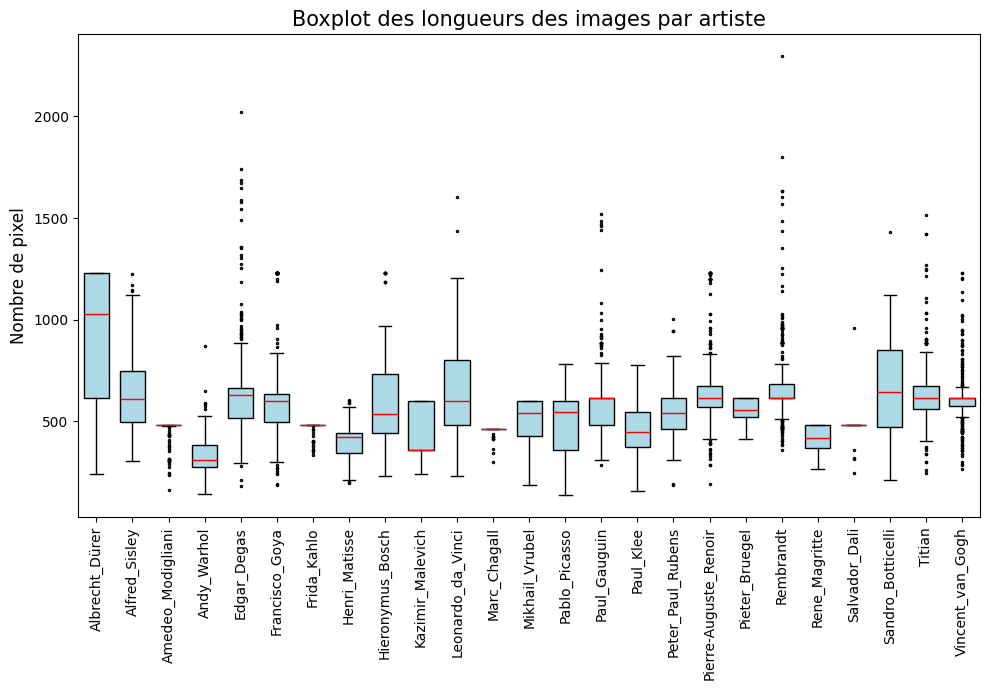

/tmp/ipykernel_47313/3163448158.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(width_per_artist,


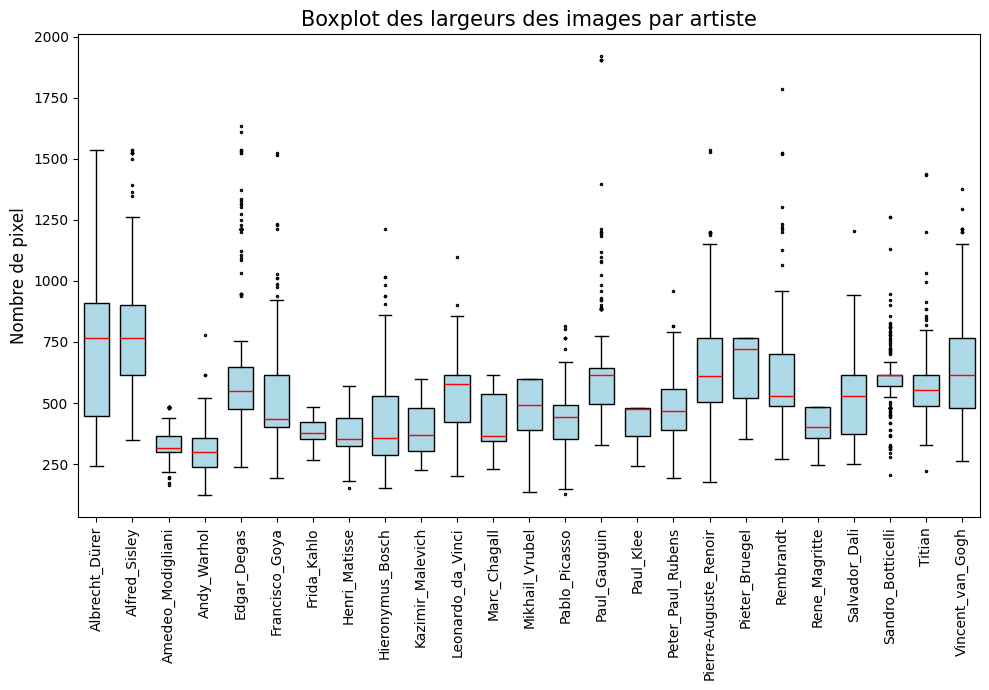

In [13]:
boxplot_dimensions_per_artist(filtered_data)

Dans ces boxplots, nous constatons que la majorité des artistes produisent des oeuvres de tailles variées. Cependant, certains artistes, tels qu'Amedeo Modigliani, Frida Kahlo, Marc Chagall et Salvador Dali, ont des peintures avec des longueurs uniformes. En revanche, la largeur des oeuvres est plus diversifiée, et aucun artiste ne présente une largeur constante pour ses tableaux. Par conséquent, nous avons décidé de ne pas inclure les dimensions initiales des oeuvres dans la classification.

### c) Etude de la nationalité et du style

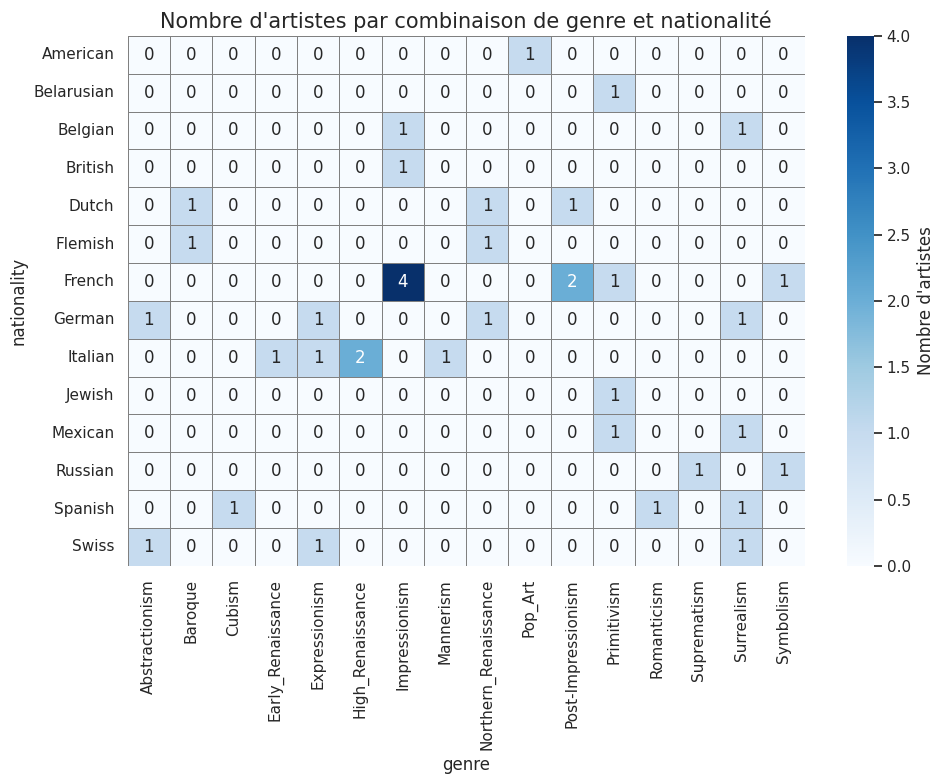

In [14]:
# Charge le fichier CSV
CSV_path = os.path.join(os.getcwd(), "art-challenge", "artists.csv")
data_artists = pd.read_csv(CSV_path)

# Mise en forme du dataframe
data_artists["name"] = data_artists["name"].str.replace(" ", "_")
data_artists["genre"] = data_artists["genre"].str.replace(" ", "_")
data_artists["genre"] = data_artists["genre"].str.split(',')
data_artists["nationality"] = data_artists["nationality"].str.split(',')

# Retire les artistes avec moins de 80 tableaux
artists_to_keep = [artist for artist in filtered_data["artist"].unique()]
data_artists = data_artists[data_artists["name"].isin(artists_to_keep)]

# Réalise un tableau croisé sur le genre et la nationalité
data_artists = data_artists.explode("genre").explode("nationality")
tableau = pd.crosstab(index = data_artists["nationality"], columns = data_artists["genre"])
sns.set(style = "whitegrid")
plt.figure(figsize = (10, 8))
sns.heatmap(tableau, annot = True, fmt = "d", cmap = "Blues", linewidths = .5, linecolor = "gray", cbar_kws = {"label": "Nombre d'artistes"})
plt.title("Nombre d'artistes par combinaison de genre et nationalité", fontsize = 15)
plt.tight_layout()
plt.show()

Nous avons envisagé d'intégrer davantage de données sur les artistes pour affiner la classification de leurs tableaux. Selon nous, les critères les plus pertinents seraient la nationalité et le genre. Bien que l'on aurait pu exploiter les biographies des artistes et extraire des éléments clés de leur vie pour les relier aux œuvres, cette approche serait bien plus complexe et nécessiterait un travail d'une autre ampleur.

En analysant le tableau à double entrée, nous constatons que la plupart des combinaisons de genre et de nationalité ne concernent qu'un seul artiste. Ajouter ces informations supplémentaires rendrait le modèle trop simple et ne justifierait pas l'utilisation d'un CNN.

De plus, bien qu'il soit possible de reconnaître un style de tableau à partir de l'image, il est moins raisonnable d'essayer de deviner la nationalité de l'artiste à partir de celle-ci. C'est pourquoi nous avons choisi de ne pas ajouter de données supplémentaires.

## 4) Préparation des données

Nous allons diviser les données en deux ensembles : data_train et data_test. Les images de l'ensemble data_train seront soumises à des techniques de data augmentation afin d'augmenter la diversité des données d'entraînement, tandis que les images de data_test resteront inchangées.

In [15]:
# Encode le nom des artistes
label_encoder = LabelEncoder()
filtered_data["artist_encoded"] = label_encoder.fit_transform(filtered_data["artist"])

# Divise les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(filtered_data, test_size = 0.3, stratify = filtered_data["artist_encoded"])

In [16]:
image_size = (528, 528)
batch_size = 20

# Augmentation des données
test_datagen = ImageDataGenerator(rescale = 1./255)

train_datagen = ImageDataGenerator(rotation_range = 40,
                                   rescale = 1./255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

# Chargement des ensembles de données
test_gen = test_datagen.flow_from_dataframe(test_data,
                                            x_col = "image_path",
                                            y_col = "artist_encoded",
                                            target_size = image_size,
                                            batch_size = batch_size,
                                            class_mode = "raw",
                                            shuffle = False)

train_gen = train_datagen.flow_from_dataframe(train_data,
                                              x_col = "image_path",
                                              y_col = "artist_encoded",
                                              target_size = image_size,
                                              batch_size = batch_size,
                                              class_mode = "raw",
                                              shuffle = True)

Found 1597 validated image filenames.
Found 3726 validated image filenames.


## 5) Entraînement du CNN

In [17]:
# Affichage et sauvegarde des courbes de loss et accuracy
def plot_history(history, path):

    if os.path.exists(path):
        plt.figure(figsize = (12, 6))
        img = plt.imread(path)
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    
    else:
        # Courbes de Loss
        plt.figure(figsize = (12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["loss"], label = "Loss (train)", color = "blue")
        plt.plot(history.history["val_loss"], label = "Loss (val)", color = "red")
        plt.title("Loss en fonction des epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
    
        # Courbes d'Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], label = "Accuracy (train)", color = "blue")
        plt.plot(history.history["val_accuracy"], label = "Accuracy (val)", color = "red")
        plt.title("Accuracy en fonction des epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
    
        plt.tight_layout()
        plt.savefig(path)
        plt.show()

### a) Premier modèle naïf

Ce premier modèle naïf est une architecture simple composée de trois couches de convolution et de max pooling. Chaque couche de convolution extrait des caractéristiques de l'image, tandis que les couches de max pooling réduisent progressivement la taille des données, ce qui aide à optimiser le modèle. À la fin, l'image est aplatie et passée à travers des couches denses pour effectuer la classification. Ce modèle sert de point de départ avant de tester des architectures plus complexes.

In [18]:
training = False

In [19]:
num_classes = len(label_encoder.classes_)

# Création du modèle CNN
model = models.Sequential([

    Input(shape = (528, 528, 3)),
    layers.Conv2D(32, (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.5),
    
    layers.Dense(num_classes, activation = "softmax")])

# Compilation du modèle
model.compile(optimizer = "adam", 
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Affichage de la structure du modèle
model.summary()

2024-12-17 17:31:35.067673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10237 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 526, 526, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 263, 263, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 261, 261, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 130, 130, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   134,217,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         6,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,317,657 (512.38 MB)

 Trainable params: 134,317,657 (512.38 MB)

 Non-trainable params: 0 (0.00 B)

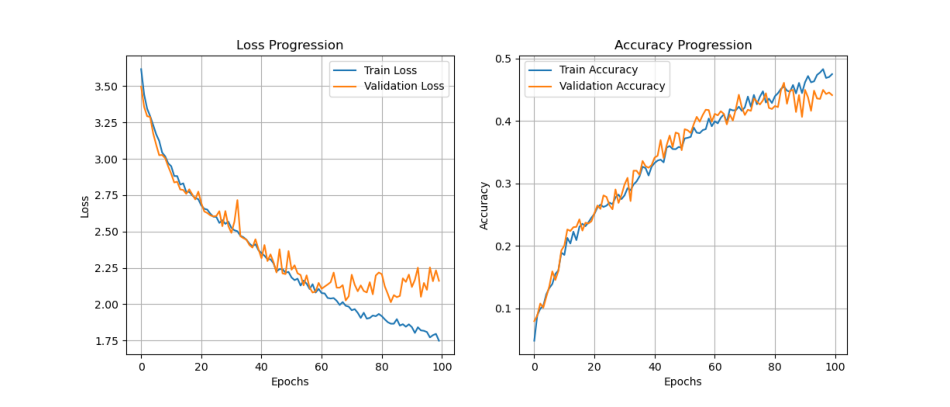

In [30]:
if training:
    # Entraînement du modèle
    history = model.fit(train_gen,
                        epochs = 100,
                        validation_data = test_gen,
                        steps_per_epoch = len(train_gen),
                        validation_steps = len(test_gen))
else:
    history = None
    
plot_history(history, os.path.join(os.getcwd(), "training_progress1.png"))

Comme prévu, les résultats de classification de ce modèle sont médiocres. Nous allons donc passer à des architectures plus complexes, notamment basées sur le transfert learning.

### b) Transfert learning et fine tuning sur EfficientNet

Nous avons ensuite étudié différents modèles préentraînés. Nos meilleurs résultats ont été obtenus avec EfficientNet. Étant donné la taille de nos entrées, nous avons choisi la version B6, qui est adaptée aux données plus grandes (528 * 528). Cela permet de limiter la perte de résolution de nos tableaux.

In [21]:
training = False

In [22]:
# Chemins des poids
training_1_weights_path = os.path.join(os.getcwd(), "training_1_weights.keras")
training_2_weights_path = os.path.join(os.getcwd(), "training_2_weights.keras")

num_classes = len(label_encoder.classes_)
input_shape = (528, 528, 3)

In [23]:
num_classes = len(label_encoder.classes_)
input_shape = (528, 528, 3)

# Chargement du modèle de base EfficientNetB6
base_model = EfficientNetB6(weights = "imagenet", include_top = False, input_shape = input_shape)

# Checkpoint pour sauvegarder les meilleurs poids
checkpoint_1 = ModelCheckpoint(training_1_weights_path, monitor = "val_loss", save_best_only = True, mode = "min", verbose = 1)

# Les 30 dernières couches sont dégelées
for layer in base_model.layers[-30:]:
    layer.trainable = True

model = models.Sequential([base_model,
                           
                           layers.GlobalAveragePooling2D(),
                           layers.Dense(512, activation = "relu"),
                           layers.BatchNormalization(),
                           layers.Dropout(0.5),
                           
                           layers.Dense(256, activation = "relu"),
                           layers.BatchNormalization(),
                           layers.Dropout(0.5),
                           
                           layers.Dense(128, activation = "relu"),
                           layers.BatchNormalization(),
                           
                           layers.Dense(num_classes, activation = "softmax")])

# Compilation du modèle
learning_rate = 1e-3
model.compile(optimizer = Adam(learning_rate = learning_rate), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)

# Affichage de la structure du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb6 (Functional)     │ (None, 17, 17, 2304)   │    40,960,143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2304)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,311,336 (161.40 MB)

 Trainable params: 42,085,105 (160.54 MB)

 Non-trainable params: 226,231 (883.72 KB)

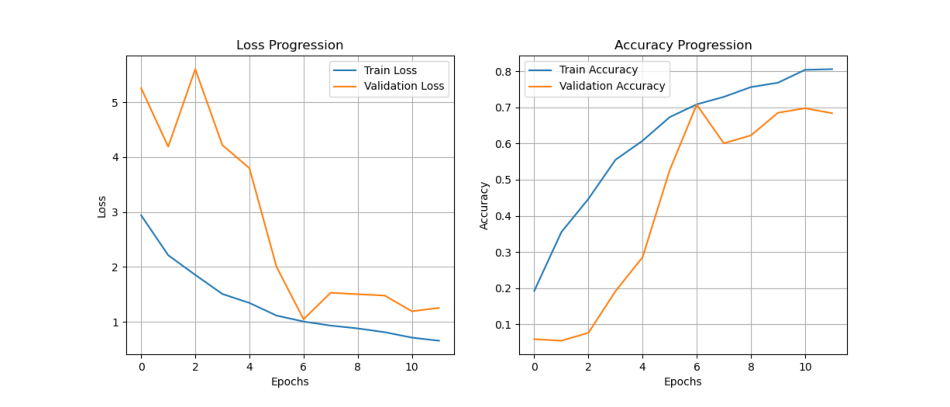

In [24]:
if training:

    # Premier entraînement du modèle
    epochs = 20
    history_1 = model.fit(train_gen,
                          validation_data = test_gen,
                          epochs = epochs,
                          callbacks = [early_stopping, checkpoint_1],
                          batch_size = batch_size)
else:
    history_1 = None

plot_history(history_1, os.path.join(os.getcwd(), "debut.png"))

In [25]:
if training:

    # Chargement des meilleurs poids sauvegardés
    model.load_weights(training_1_weights_path)
    
    # Checkpoint pour sauvegarder les meilleurs poids
    checkpoint_2 = ModelCheckpoint(training_2_weights_path, monitor = "val_loss", save_best_only = True, mode = "min", verbose = 1)
    
    # Les 50 dernières couches sont dégelées
    for layer in model.layers[0].layers[-50:]:
        layer.trainable = True
    
    # Compilation du modèle
    learning_rate = 1e-4
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)

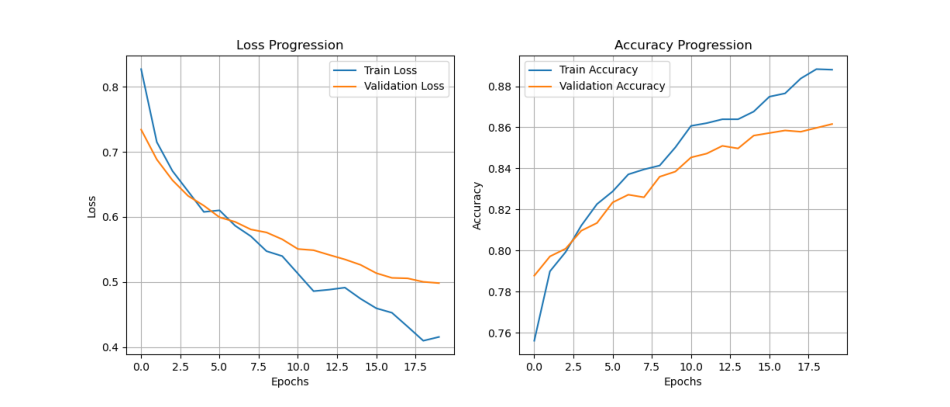

In [26]:
if training:

    # Second entraînement plus fin du modèle
    epochs = 20
    history_2 = model.fit(train_gen,
                            validation_data = test_gen,
                            epochs = epochs,
                            callbacks = [early_stopping, checkpoint_2],
                            batch_size = batch_size)
else:
    history_2 = None

plot_history(history_2, os.path.join(os.getcwd(), "fin.png"))

## 6) Résultats

In [27]:
# Chargement du modèle
model = load_model("test_save_model.h5")

I0000 00:00:1734453115.466914   47455 service.cc:146] XLA service 0x7545a80df230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734453115.466957   47455 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-12-17 17:31:55.698173: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-17 17:31:57.165357: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1734453127.582309   47455 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


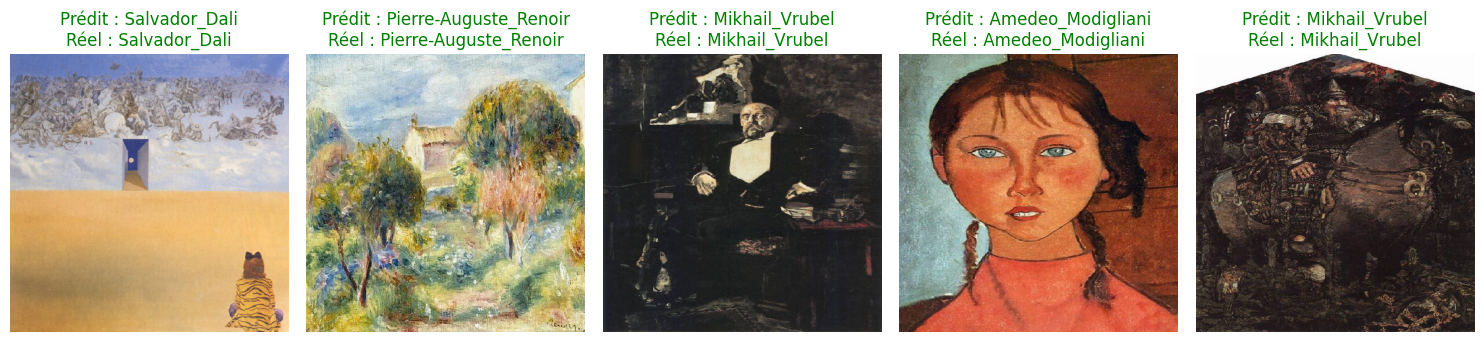

In [28]:
# Affiche des prédictions de tableaux au hasard
from tensorflow.keras.preprocessing import image


random_idx = rd.sample(range(len(test_gen.filenames)), 5)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_idx):
    image_path = test_gen.filenames[idx]
    true_artist_index = test_gen.labels[idx]
    true_artist = label_encoder.inverse_transform([true_artist_index])[0]
    img = image.load_img(image_path, target_size = (528, 528))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)
    img_array /= 255.0
    
    prediction = model.predict(img_array, verbose = 0)
    predicted_artist_index = np.argmax(prediction, axis = 1)[0]
    predicted_artist = label_encoder.inverse_transform([predicted_artist_index])[0]
    title_color = "green" if (predicted_artist == true_artist) else "red"
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title("Prédit : " + predicted_artist + "\nRéel : "+ true_artist, color = title_color)
    plt.axis("off")
plt.tight_layout()
plt.show()

Prédictions en cours : 100%|█████████████| 1597/1597 [02:52<00:00,  9.25image/s]


Accuracy :  0.8829054477144647
Precision :  0.9005719593825658
Recall :  0.8829054477144647
F1 :  0.8835563300981295


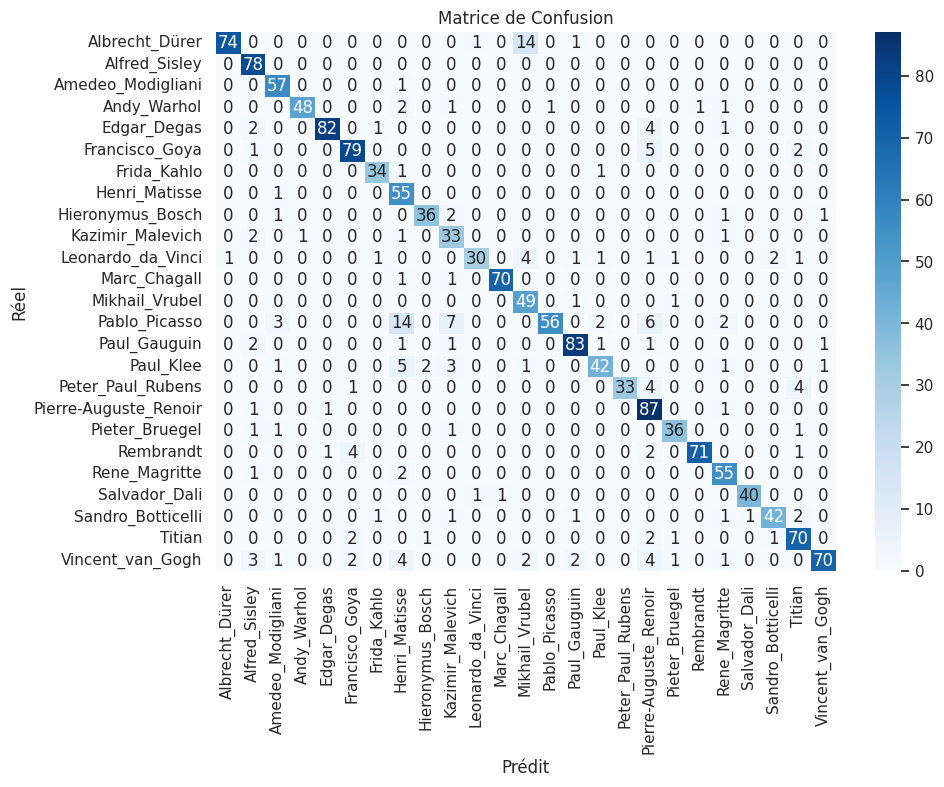

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

# Prédictions sur l'ensemble de test
true_labels = []
predicted_labels = []

for idx in tqdm(range(len(test_gen.filenames)), desc = "Prédictions en cours ", unit = "image"):
    image_path = test_gen.filenames[idx]
    true_artist_index = test_gen.labels[idx]
    true_labels.append(true_artist_index)
    
    img = image.load_img(image_path, target_size = (528, 528))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)
    img_array /= 255.0

    predictions = model.predict(img_array, verbose = 0)
    predicted_artist_index = np.argmax(predictions, axis = 1)[0]
    predicted_labels.append(predicted_artist_index)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calcul des scores
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average = "weighted")
recall = recall_score(true_labels, predicted_labels, average = "weighted")
f1 = f1_score(true_labels, predicted_labels, average = "weighted")

# Affichage des scores
print("Accuracy : ", accuracy)
print("Precision : ", precision)
print("Recall : ", recall)
print("F1 : ", f1)

# Affichage de la matrice de confusion
plt.figure(figsize = (10, 7))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de Confusion")
plt.show()